In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.image import imread
from imageio import imwrite
from scipy.fftpack import dct, idct 
import os
!pip install pylbfgs
from lbfgs import fmin_lbfgs
from math import log10, sqrt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 239 kB 5.0 MB/s 


In [ ]:
# Название файла, который будем считывать
filename = 'dicap_full.jpg'
# |Ax - b|^2 + C|x|_1 , где Коэффициент С для L1 нормы переменных
C = 5

# Процент рандомно выбранных пикселей изображения
pixels_percent = 10 

In [ ]:
# Двумерное дискретное косинусное преобразование 
def dct2(x):
    return dct(dct(x.T, norm='ortho', axis=0).T, norm='ortho', axis=0)

# Обратное думерное дискретное косинусное преобразование 
def idct2(x):
    return idct(idct(x.T, norm='ortho', axis=0).T, norm='ortho', axis=0)

# Создание гауссого шума
def gaussian_noise(X, k):
    return X + k*np.random.randn(*X.shape)

# Пиковое отношение сигнала к шуму (чем больше, тем точнее конечное изображение)
def PSNR(original, compressed):
    mse = np.mean((original - compressed) ** 2) #счиатем среднеквадратичную ошибку
    if(mse == 0):  
        return 100
    max_pixel = 255.0 #максимально возможный пиксель (если закодировать цвет, а потом раскодировать, то это будет макс число)
    psnr = 20 * log10(max_pixel / sqrt(mse)) #вычисление значения psnr по определению
    return psnr

In [ ]:
# cчитаем оригинальное изображение
X_color = imread(filename)
#X_color = gaussian_noise(X_color, 50)
nx, ny = X_color.shape[0], X_color.shape[1]
print('Image size: ' + str(nx) + ' x ' + str(ny))

k = round(nx * ny * (pixels_percent / 100))

# создаем вектор индексов случайной выборки
ri = np.random.choice(nx * ny, k, replace=False)

# конвертируем цветное изображение в черно - белое 
X_gray = X_color.mean(-1)

# добавляем шум в изображение
#X_gray = gaussian_noise(X_gray, 50)

# создаем изображение маски ( для визуализации )
X_mask = 255 * np.ones(X_gray.shape)
X_mask.flat[ri] = X_gray.flat[ri]

# берем случайные пиксели изображения, сохраняем их в вектор b
b = X_gray.flat[ri].astype(float)

Image size: 701 x 499


In [ ]:
%%time
def evaluate(x, g, *args):
    """An in-memory evaluation callback."""
    # мы хотим, чтобы функция evaluate вычисляла 2 вещи:
    # (1) норма, возведенная в квадрат, sum((Ax-b).^2) и 
    # (2) градиент 2*A'(Ax-b)

    # x - предположительное решение задачи оптимизации |Ax - b|^2 + C|x|_1
    # т.е. x - разреженная матрица изображения в базисе косинусного преобразования

    # Ax - это обратное 2D дискретное косинусное преобразование матрицы x
    Ax2 = idct2(x)

    # делаем случайные измерения матрицы Ax2
    Ax = Ax2.flat[ri]

    # вычисляем остаточный член Ax-b и его 2-норму в квадрате
    Axb = Ax - b
    fx = np.sum(np.power(Axb, 2))

    # спроецируем осаточный вектор размера (k x 1) на пустое изображение размера (ny x nx)
    Axb2 = np.zeros(x.shape)
    Axb2.flat[ri] = Axb

    # A'(Ax-b) - это дискретное двумерное косинусное преобразование матрицы Axb2
    AtAxb = 2 * dct2(Axb2)

    # скопируем вектор градиента для алгоритма оптимизации
    np.copyto(g, AtAxb)

    return fx


# выполним L1 минимизацию в памяти
'''
Orthant-Wise Limited-memory Quasi-Newton (OWL-QN) метод, который
минимизирует целевую функцию F(x) в сочетании с L1 нормой (абсолютная
сумма переменных), {F(x) + C|x|}
'''
x0 = np.zeros((nx, ny))
X_result = fmin_lbfgs(evaluate, x0, orthantwise_c=C, line_search='wolfe')

# применим обратное двумерное косинусное преобразования к результату
X_restored = idct2(X_result)

CPU times: user 16.3 s, sys: 96.2 ms, total: 16.4 s
Wall time: 16.4 s


Image size: 701 x 499
10% percent pixel restoration
C = 5
PSNR: 27.643623169661552


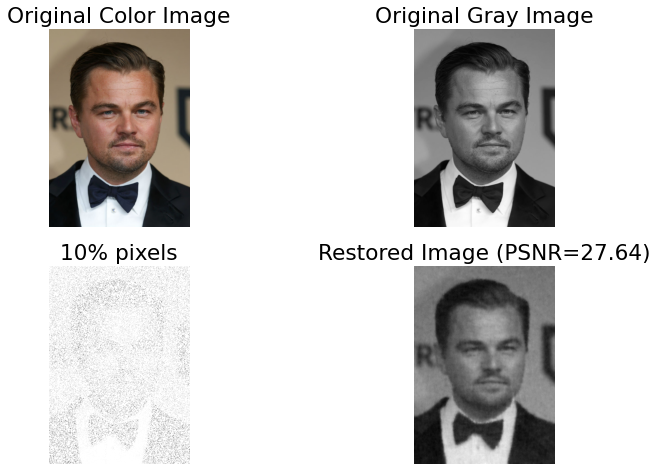

In [ ]:
# Демонстрируем результат

# Выводим основную информацию
image_psnr = PSNR(X_gray, X_restored)
print('Image size: ' + str(nx) + ' x ' + str(ny))
print(str(pixels_percent) + '% percent pixel restoration')
print('C = ' + str(C))
print('PSNR: ' + str(image_psnr))

# Создаём полотно для вывода результатов
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams.update({'font.size': 18})

fig, axs = plt.subplots(2, 2)

# Оригинальное изображение
axs[0][0].set_title('Original Color Image')
axs[0][0].imshow(X_color)
axs[0][0].axis('off')

# Оригинальное черно - белое изображение
axs[0][1].set_title('Original Gray Image')
axs[0][1].imshow(X_gray, cmap='gray')
axs[0][1].axis('off')

# Выборка из 10 % пикселей
axs[1][0].set_title(str(pixels_percent) + '% pixels')
axs[1][0].imshow(X_mask, cmap='gray')
axs[1][0].axis('off')

# Итоговый результат
axs[1][1].set_title('Restored Image (PSNR=' + str(round(image_psnr, 2)) + ')')
axs[1][1].imshow(X_restored, cmap='gray')
axs[1][1].axis('off')
plt.show()

In [ ]:
# сохраняем результат
imwrite(os.path.join('restored_' + filename), X_restored)